<a href="https://colab.research.google.com/github/fadhellassoued/ECG-Based-Arrhythmia-Classification/blob/main/ECG_Arrhythmia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
from google.colab import files
uploaded = files.upload()

Saving mitbih_test.csv to mitbih_test.csv
Saving mitbih_train.csv to mitbih_train.csv


In [4]:
train_data = pd.read_csv("mitbih_train.csv", header=None)
test_data = pd.read_csv("mitbih_test.csv", header=None)

###Exploratory Data Analysis

In [5]:
# Show the shape and the first few rows of the train_data
train_data.shape

(87554, 188)

In [6]:
train_data.iloc[:, -1].value_counts().sort_index()

,count
187,
0.0,72471
1.0,2223
2.0,5788
3.0,641
4.0,6431


In [7]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
test_data.shape

(21892, 188)

In [9]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64
0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64


In [11]:
train_data.iloc[:, -1].unique()

array([0., 1., 2., 3., 4.])

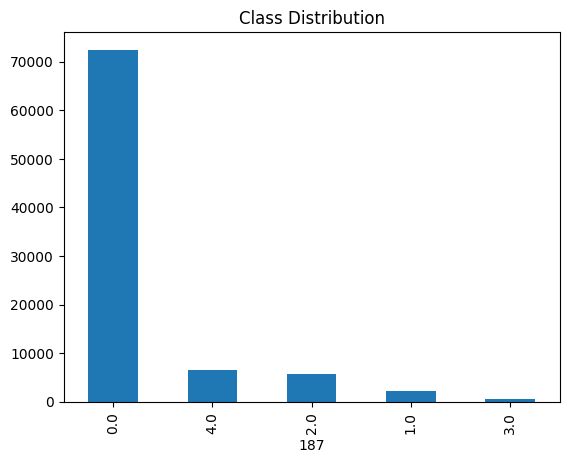

In [12]:
train_data.iloc[:, -1].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

###Seperate features and labels

In [13]:
X_train=train_data.iloc[:,:-1].values
y_train=train_data.iloc[:,-1].values

X_test=test_data.iloc[:,:-1].values
y_test=test_data.iloc[:,-1].values

###Normalize the ECG signals

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

###visualize Random Heartbeats from the train_data

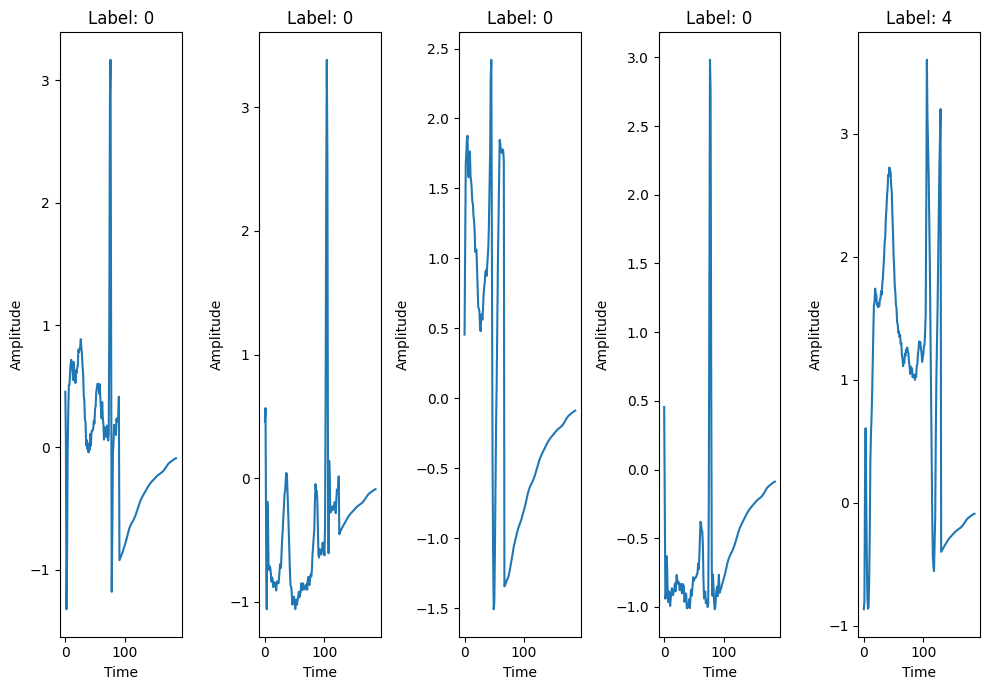

In [15]:
#Shuffle the train_data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)
plt.figure(figsize=(10, 7))
import random
random_indices = random.sample(range(len(X_train)), 5)
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.plot(X_train[idx])
    plt.title(f"Label: {int(y_train[idx])}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
#plt.suptitle("Random Heartbeats from Training Data", fontsize=16)
plt.show();

###Convert to a PyTorch Dataset

In [16]:
from torch.utils.data import Dataset, DataLoader

class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [17]:
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fda82929cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fda829a9190>)

###Generate Wavelet Features(for Dual Branch)

In [18]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.5 MB/s eta 0:00:00


In [19]:
import pywt

In [20]:
# --- Wavelet Feature Extraction ---
def compute_wavelet(signal):
    coeffs, _ = pywt.cwt(signal, scales=np.arange(1, 31), wavelet='morl')
    return np.abs(coeffs).mean(axis=0)  # simple summary

# Apply to all training and testing data
wavelet_train = np.array([compute_wavelet(x) for x in X_train])
wavelet_test = np.array([compute_wavelet(x) for x in X_test])

###Define Dual_Branch Transformer model
####Each branch: 1D Transformer for raw or wavelet input
####Then: Concatenate → FC Layer → Classification

In [21]:
import torch.nn as nn

class ECGTransformer(nn.Module):
    def __init__(self, input_len):
        super(ECGTransformer, self).__init__()

        self.raw_branch = nn.Sequential(
            nn.Linear(input_len, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        self.freq_branch = nn.Sequential(
            nn.Linear(input_len, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 5)  # 5 classes
        )

    def forward(self, raw, freq):
        raw_out = self.raw_branch(raw)
        freq_out = self.freq_branch(freq)
        combined = torch.cat((raw_out, freq_out), dim=1)
        return self.classifier(combined)

model=ECGTransformer(input_len=X_train.shape[1]).to(device)
model

ECGTransformer(
  (raw_branch): Sequential(
    (0): Linear(in_features=187, out_features=128, bias=True)
    (1): ReLU()
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (freq_branch): Sequential(
    (0): Linear(in_features=187, out_features=128, bias=True)
    (1): ReLU()
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=5, bias=True)
  )
)

###Training loop

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [24]:
torch.manual_seed(42)
epochs=3
for epoch in range(epochs):
    model.train()
    for i, (raw, labels) in enumerate(train_dataloader):
        raw, labels = raw.to(device), labels.to(device)
        freq = torch.tensor([compute_wavelet(x.cpu().numpy()) for x in raw]).to(device)

        y_preds = model(raw, freq)
        loss = loss_fn(y_preds, labels)
        acc=accuracy_fn(labels,y_preds.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch+1} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% ")

Epoch: 1 | Loss: 0.01596, Accuracy: 100.00% 
Epoch: 2 | Loss: 0.01383, Accuracy: 100.00% 
Epoch: 3 | Loss: 0.00263, Accuracy: 100.00% 


##As we can see our model is overfitting
## modifications to prevent overfitting:
####Data augmentation:

In [25]:
# Data Augmentation
import torch.nn.functional as F
class ECGAugmentation:
    def __call__(self, x):
        # Add random noise
        x += torch.randn_like(x) * 0.01
        # Random time warping
        # Fix: Use a fixed scaling factor for all samples in the batch
        scale_factor = random.uniform(0.9, 1.1)  # Generate scale factor outside loop
        if random.random() > 0.5:
            x = F.interpolate(x.unsqueeze(0).unsqueeze(0),
                            scale_factor=scale_factor, # Use fixed factor
                            mode='linear').squeeze()
        # Pad or truncate to ensure consistent length
        target_len = 187  # Choose the desired length
        x = F.pad(x, (0, target_len - len(x))) if len(x) < target_len else x[:target_len]
        return x

# Create augmented dataset
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, augment):
        self.dataset = dataset
        self.augment = augment

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.augment:
            x = self.augment(x)
        return x, y

augment = ECGAugmentation()

In [26]:
train_dataset = AugmentedDataset(train_dataset, augment)

In [27]:
test_dataset=AugmentedDataset(test_dataset, augment)

####Handle class imbalance

In [28]:
# Handle class imbalance
# Convert y_train to integers before using np.bincount
y_train_int = y_train.astype(int)
class_counts = np.bincount(y_train_int)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights.to(device)

In [29]:
# Model Architecture (Dual-Branch Transformer)
class ECGTransformerV1(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.5):
        super(ECGTransformerV1, self).__init__()

          # Add gradient clipping in your training loop
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Temporal branch
        self.temporal_proj = nn.Linear(input_dim, 64)
        self.temporal_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=64, nhead=8, dim_feedforward=256),
            num_layers=2
        )

        # Frequency branch (assuming wavelet features)
        self.freq_proj = nn.Linear(input_dim, 64)
        self.freq_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=64, nhead=8, dim_feedforward=256),
            num_layers=2
        )

        # Combine branches
        self.combine = nn.Linear(128, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(64, num_classes)

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)

    def forward(self, x):
        # Temporal branch
        x_temp = self.temporal_proj(x)
        x_temp = self.bn1(x_temp.transpose(1, 2)).transpose(1, 2)
        x_temp = self.temporal_transformer(x_temp)
        x_temp = x_temp.mean(dim=1)

        # Frequency branch (using same input for demo - replace with wavelet features)
        x_freq = self.freq_proj(x)
        x_freq = self.bn2(x_freq.transpose(1, 2)).transpose(1, 2)
        x_freq = self.freq_transformer(x_freq)
        x_freq = x_freq.mean(dim=1)

        # Combine branches
        x = torch.cat([x_temp, x_freq], dim=1)
        x = self.combine(x)
        x = self.dropout(x)
        x = self.classifier(x)

        return x
model_1=ECGTransformerV1(input_dim=X_train.shape[1],num_classes=5).to(device)
model_1


ECGTransformerV1(
  (temporal_proj): Linear(in_features=187, out_features=64, bias=True)
  (temporal_transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (freq_proj): Linear(in_features=187, out_features=64, bias=True)
  (freq_transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): M

In [30]:
# Loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


In [31]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [32]:
torch.manual_seed(42)
epochs=3

for epoch in range(epochs):
    model.train()
    #loss = 0
    #correct = 0
    #total = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Calculate frequency features
        freq = torch.tensor([compute_wavelet(x.cpu().numpy()) for x in inputs]).to(device)

        # Forward pass with both raw and frequency data
        outputs = model(inputs, freq)
        loss = loss_fn(outputs, labels)
        acc=accuracy_fn(labels,outputs.argmax(dim=1))
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch+1} | Loss: {loss:.4f} , Accuracy: {acc:.2f}%")

Epoch: 1 | Loss: 0.1183 , Accuracy: 100.00%
Epoch: 2 | Loss: 0.0020 , Accuracy: 100.00%
Epoch: 3 | Loss: 0.2595 , Accuracy: 100.00%


###As we see our model is still overfitting , we need other modifications

### Modifications to prevent overfitting part 2: We will:
#####apply cross-validation on the training data.
#####Make advanced data augmentation
#####Add Early stopping

###Apply cross validation

In [33]:
from sklearn.model_selection import StratifiedKFold

X = train_data.iloc[:,:-1].values
y = train_data.iloc[:,-1].values

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f'\nFOLD {fold + 1}')
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


FOLD 1

FOLD 2

FOLD 3

FOLD 4

FOLD 5


In [34]:
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [35]:
train_dataset = ECGDataset(X_train, y_train)
val_dataset = ECGDataset(X_val, y_val)

In [36]:

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fda4a66ab50>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdba87b5c50>)

In [37]:
# --- Wavelet Feature Extraction ---
def compute_wavelet(signal):
    coeffs, _ = pywt.cwt(signal, scales=np.arange(1, 31), wavelet='morl')
    return np.abs(coeffs).mean(axis=0)

# Apply to all training and validation data
wavelet_train = np.array([compute_wavelet(x) for x in X_train])
wavelet_val = np.array([compute_wavelet(x) for x in X_val])

###Advanced Data Augmentation

In [38]:
#class ECGAugmentation:
#    def __call__(self, x):
        # Add random noise
#        x += torch.randn_like(x) * 0.01
        # Random time warping
#        if random.random() > 0.5:
#            x = F.interpolate(x.unsqueeze(0).unsqueeze(0),
#                            scale_factor=random.uniform(0.9, 1.1),
#                            mode='linear').squeeze()
#        return x
class ECGAugmentation:
    def __call__(self, x):
        # Existing augmentations
        x += torch.randn_like(x) * 0.01

        # New augmentations:
        # Random scaling
        scale = random.uniform(0.8, 1.2)
        x = x * scale

        # Random channel dropout
        if random.random() < 0.1:
            chan = random.randint(0, x.size(0)-1)
            x[chan] = 0

        return x

# Create augmented dataset
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, augment):
        self.dataset = dataset
        self.augment = augment

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.augment:
            x = self.augment(x)
        return x, y

augment = ECGAugmentation()
train_dataset = AugmentedDataset(train_dataset, augment)

###Handle class imbalance

In [39]:
class_counts = np.bincount(y_train.astype(int))
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights.to(device)

In [40]:
# Model Architecture (Dual-Branch Transformer)
class ECGTransformerV3(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.5):
        super(ECGTransformerV3, self).__init__()

        # Temporal branch
        self.temporal_proj = nn.Linear(input_dim, 64)
        self.temporal_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=64, nhead=8, dim_feedforward=256),
            num_layers=3
        )

        # Frequency branch (assuming wavelet features)
        self.freq_proj = nn.Linear(input_dim, 64)
        self.freq_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=64, nhead=8, dim_feedforward=256),
            num_layers=3
        )

        # Combine branches
        self.combine = nn.Linear(128, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(64, num_classes)

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)

    def forward(self, x):
        # Temporal branch
        x_temp = self.temporal_proj(x)
        x_temp = self.bn1(x_temp.transpose(1, 2)).transpose(1, 2)
        x_temp = self.temporal_transformer(x_temp)
        x_temp = x_temp.mean(dim=1)

        # Frequency branch (using same input for demo - replace with wavelet features)
        x_freq = self.freq_proj(x)
        x_freq = self.bn2(x_freq.transpose(1, 2)).transpose(1, 2)
        x_freq = self.freq_transformer(x_freq)
        x_freq = x_freq.mean(dim=1)

        # Combine branches
        x = torch.cat([x_temp, x_freq], dim=1)
        x = self.combine(x)
        x = self.dropout(x)
        x = self.classifier(x)

        return x

model_3 = ECGTransformerV3(input_dim=X_train.shape[1], num_classes=5).to(device)
model_3

ECGTransformerV3(
  (temporal_proj): Linear(in_features=187, out_features=64, bias=True)
  (temporal_transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (freq_proj): Linear(in_features=187, out_features=64, bias=True)
  (freq_transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): M

In [41]:
# Loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


###Training loop:

In [42]:
best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
epochs=3
for epoch in range(epochs):
  model_3.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in train_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
    outputs = model_3(inputs.unsqueeze(1))
    loss = loss_fn(outputs, labels)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

        # Validation
  model_3.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for inputs, labels in val_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model_3(inputs.unsqueeze(1))
      loss = loss_fn(outputs, labels)

      val_loss += loss.item()
      _, predicted = outputs.max(1)
      val_total += labels.size(0)
      val_correct += predicted.eq(labels).sum().item()

      # Calculate metrics
  train_loss = running_loss / len(train_dataloader)
  val_loss = val_loss / len(val_dataloader)
  train_acc = 100. * correct / total
  val_acc = 100. * val_correct / val_total

  # Update learning rate
  scheduler.step(val_loss)

        # Store metrics
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accs.append(train_acc)
  val_accs.append(val_acc)

  print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.2f}%')

        # Early stopping check
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model_3.state_dict(), 'best_model.pth')
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= patience:
      print("Early stopping triggered")
      break

Epoch: 0 | Train Loss: 0.66249, Train Acc: 70.15% | Val Loss: 0.83657, Val Acc: 69.65%
Epoch: 1 | Train Loss: 0.50891, Train Acc: 79.67% | Val Loss: 0.62242, Val Acc: 79.19%
Epoch: 2 | Train Loss: 0.44966, Train Acc: 82.01% | Val Loss: 0.49907, Val Acc: 83.31%


###As observed in the training results, there is some fluctuation in the validation accuracy across epochs.

####Minimize fluctuation in the val accuracy

In [43]:
# Loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001, weight_decay=1e-4,eps=1e-8)

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1,patience=3, verbose=True)

###Training loop

In [44]:
best_val_loss = float('inf')
patience = 5
patience_counter = 0
accumulation_steps = 2
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epochs=6
for epoch in range(epochs):
  model_3.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for i,(inputs, labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
    with torch.cuda.amp.autocast():
      outputs = model_3(inputs.unsqueeze(1))
      loss = loss_fn(outputs, labels)/accumulation_steps

    # Backward pass and optimizer
    loss.backward()
    if (i + 1) % accumulation_steps == 0:
        torch.nn.utils.clip_grad_norm_(model_3.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

    running_loss += loss.item()
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

        # Validation
  model_3.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for inputs, labels in val_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model_3(inputs.unsqueeze(1))
      loss = loss_fn(outputs, labels)

      val_loss += loss.item()
      _, predicted = outputs.max(1)
      val_total += labels.size(0)
      val_correct += predicted.eq(labels).sum().item()

      # Calculate metrics
  train_loss = running_loss / len(train_dataloader)
  val_loss = val_loss / len(val_dataloader)
  train_acc = 100. * correct / total
  val_acc = 100. * val_correct / val_total

  # Update learning rate
  scheduler.step(val_loss)

        # Store metrics
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accs.append(train_acc)
  val_accs.append(val_acc)

  print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.2f}%')

        # Early stopping check
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model_3.state_dict(), 'best_model.pth')
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= patience:
      print("Early stopping triggered")
      break

Epoch: 1 | Train Loss: 0.18549, Train Acc: 88.19% | Val Loss: 0.31508, Val Acc: 90.33%
Epoch: 2 | Train Loss: 0.17027, Train Acc: 89.61% | Val Loss: 0.29291, Val Acc: 90.81%
Epoch: 3 | Train Loss: 0.16061, Train Acc: 90.61% | Val Loss: 0.33327, Val Acc: 88.83%
Epoch: 4 | Train Loss: 0.14876, Train Acc: 90.96% | Val Loss: 0.35716, Val Acc: 87.90%
Epoch: 5 | Train Loss: 0.14383, Train Acc: 91.01% | Val Loss: 0.21398, Val Acc: 93.15%
Epoch: 6 | Train Loss: 0.13769, Train Acc: 91.73% | Val Loss: 0.26232, Val Acc: 91.74%


###Training and testing loop

In [45]:
best_val_loss = float('inf')
patience = 5
patience_counter = 0
accumulation_steps = 2
train_losses, val_losses ,test_losses= [], [],[]
train_accs, val_accs,test_accs = [], [],[]
epochs=10
for epoch in range(epochs):
  model_3.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for i,(inputs, labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
    with torch.cuda.amp.autocast():
      outputs = model_3(inputs.unsqueeze(1))
      loss = loss_fn(outputs, labels)/accumulation_steps

    # Backward pass and optimizer
    loss.backward()
    if (i + 1) % accumulation_steps == 0:
        torch.nn.utils.clip_grad_norm_(model_3.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

    running_loss += loss.item()
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

        # Validation
  model_3.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for inputs, labels in val_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model_3(inputs.unsqueeze(1))
      loss = loss_fn(outputs, labels)

      val_loss += loss.item()
      _, predicted = outputs.max(1)
      val_total += labels.size(0)
      val_correct += predicted.eq(labels).sum().item()

        # Testing
  model_3.eval()
  test_loss = 0.0
  test_correct = 0
  test_total = 0

  with torch.no_grad():
    for inputs, labels in test_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model_3(inputs.unsqueeze(1))
      loss = loss_fn(outputs, labels)

      test_loss += loss.item()
      _, predicted = outputs.max(1)
      test_total += labels.size(0)
      test_correct += predicted.eq(labels).sum().item()


      # Calculate metrics
  train_loss = running_loss / len(train_dataloader)
  val_loss = val_loss / len(val_dataloader)
  test_loss=test_loss/len(test_dataloader)
  train_acc = 100. * correct / total
  val_acc = 100. * val_correct / val_total
  test_acc=100.*test_correct/test_total

  # Update learning rate
  scheduler.step(test_loss)

        # Store metrics
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  test_losses.append(test_loss)
  train_accs.append(train_acc)
  val_accs.append(val_acc)
  test_accs.append(test_acc)

  print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.2f}% |'
              f'Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%')

        # Early stopping check
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model_3.state_dict(), 'best_model.pth')
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= patience:
      print("Early stopping triggered")
      break

Epoch: 1 | Train Loss: 0.12840, Train Acc: 91.99% | Val Loss: 0.25362, Val Acc: 92.23% |Test Loss: 0.31572, Test Acc: 90.08%
Epoch: 2 | Train Loss: 0.12521, Train Acc: 92.18% | Val Loss: 0.26499, Val Acc: 91.01% |Test Loss: 0.31248, Test Acc: 89.62%
Epoch: 3 | Train Loss: 0.12486, Train Acc: 92.61% | Val Loss: 0.23739, Val Acc: 92.52% |Test Loss: 0.28944, Test Acc: 90.72%
Epoch: 4 | Train Loss: 0.08796, Train Acc: 94.39% | Val Loss: 0.17781, Val Acc: 94.65% |Test Loss: 0.21974, Test Acc: 93.15%
Epoch: 5 | Train Loss: 0.07889, Train Acc: 95.13% | Val Loss: 0.18161, Val Acc: 94.36% |Test Loss: 0.23166, Test Acc: 92.79%
Epoch: 6 | Train Loss: 0.07180, Train Acc: 95.33% | Val Loss: 0.17397, Val Acc: 94.61% |Test Loss: 0.22661, Test Acc: 92.87%
Epoch: 7 | Train Loss: 0.07094, Train Acc: 95.59% | Val Loss: 0.17646, Val Acc: 94.49% |Test Loss: 0.23989, Test Acc: 92.60%
Epoch: 8 | Train Loss: 0.06560, Train Acc: 95.55% | Val Loss: 0.15818, Val Acc: 95.22% |Test Loss: 0.20874, Test Acc: 93.57%


In [46]:
model_3_results = pd.DataFrame([{
    'model_name': model_3.__class__.__name__,
    'model_loss': test_loss,
    'model_acc': test_acc
}])

model_3_results

,model_name,model_loss,model_acc
0,ECGTransformerV3,0.196607,94.112004


##Make and evaluate random prediction with our best model

In [47]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device
            # Reshape the sample to have 3 dimensions for the model input (unsqueeze on dim=1)
            sample = sample.unsqueeze(1)
            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [48]:
import random
#random.seed(42)
test_samples = []
test_labels = []
# Get a list of random row indices
random_indices = random.sample(range(len(test_data)), k=9)

# Use the indices to access data and labels
for idx in random_indices:
    # Convert sample to PyTorch tensor
    sample = torch.tensor(test_data.iloc[idx, :-1].values, dtype=torch.float32)
    label = test_data.iloc[idx, -1]
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]}")

Test sample image shape: torch.Size([187])
Test sample label: 4.0


In [49]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_3,
                             data=test_samples)

# View first 5 prediction probabilities list
pred_probs[:5]

tensor([[9.9013e-01, 8.2197e-03, 9.7462e-04, 2.3028e-04, 4.4134e-04],
        [9.9019e-01, 8.2787e-03, 1.4987e-03, 6.7641e-06, 2.2460e-05],
        [9.9899e-01, 9.7043e-04, 3.6760e-05, 2.8983e-06, 1.5091e-06],
        [9.7594e-01, 2.3738e-02, 2.8790e-04, 2.9216e-05, 2.7378e-06],
        [9.6883e-01, 3.0086e-02, 1.0080e-03, 2.4647e-05, 5.0520e-05]])

In [50]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
# Are our predictions in the same form as our test labels?
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
print(f'test labels :{test_labels_tensor}')
print(f'pred calsses:{pred_classes}')

test labels :tensor([4, 0, 0, 0, 0, 0, 0, 0, 0])
pred calsses:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])


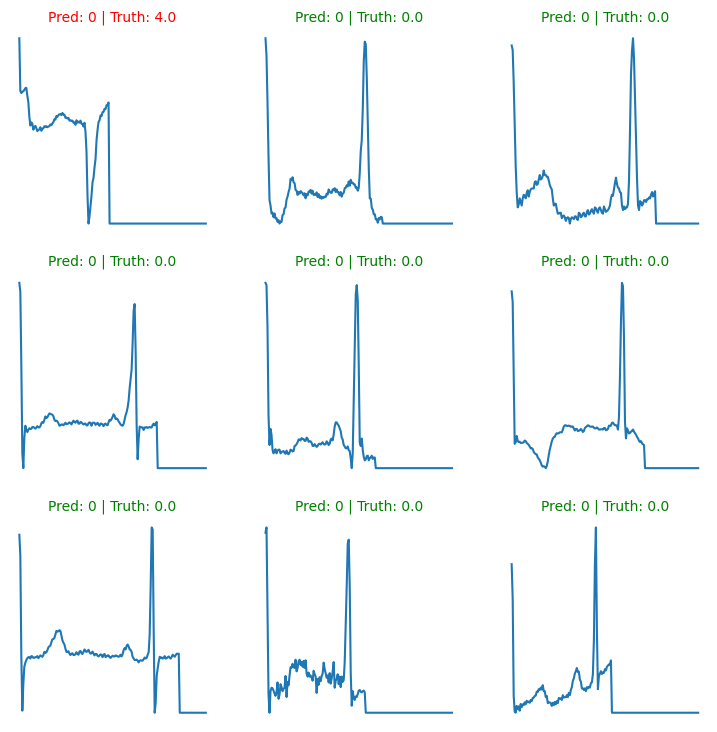

In [52]:
#Now let's visualize:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  plt.plot(sample.squeeze())

  # Find the prediction label (in text form, e.g. "0")
  pred_label = pred_classes[i]

  # Get the truth label (in text form, e.g. "2")
  truth_label = test_labels[i]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

###Making a confusion matrix for further prediction evaluation :

In [53]:
from tqdm.auto import tqdm
y_preds=[]
model_3.eval()
with torch.no_grad():
  for input, label in tqdm(test_dataloader,desc='Making predictions'):
    input, label = input.to(device), label.to(device)
    y_pred = model_3(input.unsqueeze(1))
    #Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/343 [00:00<?, ?it/s]

In [54]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [55]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.23.4


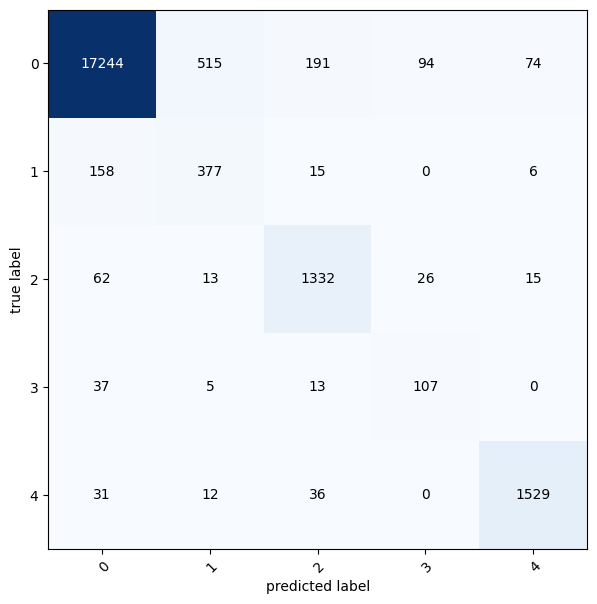

In [56]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 'y_test' contains the target labels
confmat = ConfusionMatrix(num_classes=5, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor.argmax(dim=1),
                         target=torch.tensor(y_test, dtype=torch.int64))  # Convert y_test to a PyTorch tensor

# Define class names
class_names = ['0', '1', '2', '3', '4']

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

Normalized confusion matrix


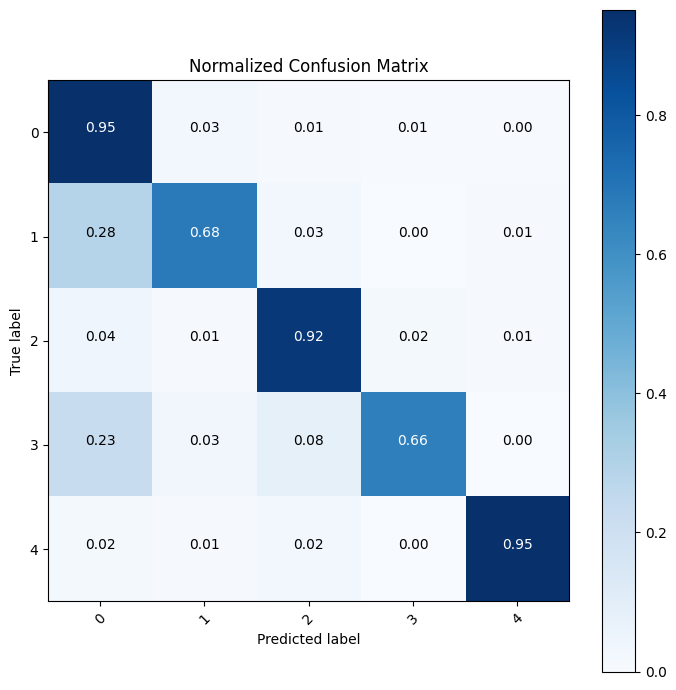

In [57]:
from sklearn.metrics import confusion_matrix
import itertools
import torch

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Displays the confusion matrix with or without normalization.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred_labels = y_pred_tensor.argmax(dim=1).cpu().numpy()
y_true_labels = torch.tensor(y_test).cpu().numpy()

# --- Compute the confusion matrix using scikit-learn ---
cnf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix,
                      classes= ['0', '1', '2', '3', '4'],
                      normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()


In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels, digits=4))

              precision    recall  f1-score   support

         0.0     0.9836    0.9518    0.9674     18118
         1.0     0.4089    0.6781    0.5101       556
         2.0     0.8393    0.9199    0.8778      1448
         3.0     0.4714    0.6605    0.5501       162
         4.0     0.9415    0.9509    0.9462      1608

    accuracy                         0.9405     21892
   macro avg     0.7289    0.8322    0.7703     21892
weighted avg     0.9526    0.9405    0.9452     21892



###Interpretation of the results of the confusion matrix and classification report:   
####* for class 0: Excellent : we have high precision and recall
####* for class 1: Low precision: there's many false positives , but decent recall
####* for class 2: Very good:well balanced
####* for class 3:similar to class 1: recall is good but precision needs work
####* for class 4: Ecellent: well handled

###Overall Metrics:
####Accuracy: 95.29% --strong overall
####Macro avg F1: 0.8082 --Shows that class imbalance is affecting smaller classes
####Weighted avg F1: 0.9560-- reflects strong performance due to dominance of class 0

##Save and load our best performing model

In [59]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True )

# Create model save path
MODEL_NAME = "ECG_arrhythmia_classification_model_3.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_3.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/ECG_arrhythmia_classification_model_3.pth


#####Now we've got a saved model state_dict() we can load it back in using a combination of load_state_dict() and torch.load().

#####Since we're using load_state_dict(), we'll need to create a new instance of ECGTransformerV3() with the same input parameters as our saved model state_dict()

In [60]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
#Provide input_dim and num_classes while creating an instance of ECGTransformerV3
loaded_model_3 = ECGTransformerV3(input_dim=X_train.shape[1],num_classes=5)

# Load in the saved state_dict()
loaded_model_3.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_3= loaded_model_3.to(device)

In [61]:
# iterate through the keys and compare individual tensors using torch.equal()
all_equal = True
for key in loaded_model_3.state_dict():
    if not torch.equal(loaded_model_3.state_dict()[key], loaded_model_3.state_dict()[key]):
        all_equal = False
        break

print(all_equal)  # This will print True if all tensors are equal

True


####Now that we've got a loaded model we can evaluate it to make sure its parameters work similarly to model_3 prior to saving

In [62]:
for epoch in range(10):
  loaded_model_3.eval()
  loaded_test_loss = 0.0
  test_correct = 0
  test_total = 0

  with torch.no_grad():
    for inputs, labels in test_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = loaded_model_3(inputs.unsqueeze(1))
      loss = loss_fn(outputs, labels)

      loaded_test_loss += loss.item()
      _, predicted = outputs.max(1)
      test_total += labels.size(0)
      test_correct += predicted.eq(labels).sum().item()


      # Calculate metrics
  loaded_test_loss=loaded_test_loss/len(test_dataloader)
  loaded_test_acc=100.*test_correct/test_total

  # Update learning rate
  scheduler.step(test_loss)


In [63]:
loaded_model_3_results = pd.DataFrame([{
    'model_name': loaded_model_3.__class__.__name__,
    'model_loss': loaded_test_loss,
    'model_acc': loaded_test_acc
}])
loaded_model_3_results

,model_name,model_loss,model_acc
0,ECGTransformerV3,0.195705,94.002375


In [64]:
model_3_results

,model_name,model_loss,model_acc
0,ECGTransformerV3,0.196607,94.112004
